In [255]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## Functions

In [256]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [257]:
def plot_hist_normalized(this_column):
    pt = PowerTransformer()
    col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    sc = StandardScaler()
    col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")
    qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
    col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")

In [258]:
def boxplots_for_all_numerical_cols(this_df):
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [259]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [260]:
def all_numeric_to_int(this_df):
    for col in split_df_in_numeric_categ_dfs(this_df)[0]:
        this_df[col] = this_df[col].astype(np.int64)


## Read and Clean

In [261]:
ca_df = pd.read_csv("C:/Users/roman/Documents/GitHub/Customer_Data_Analysis/Data/marketing_cust_analysis_round2.csv")
ca_df.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size', 'vehicle_type', 'month'],
      dtype='object')

### Numerical columns

#### Boxplots

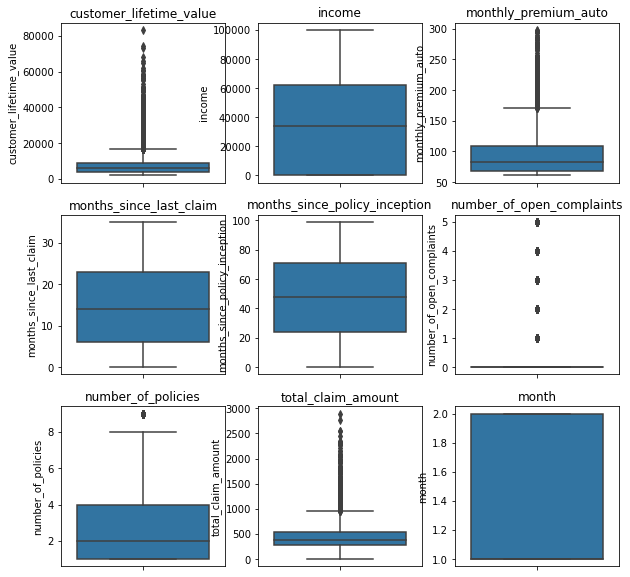

In [262]:
boxplots_for_all_numerical_cols(ca_df)

#### Check for NaNs

In [263]:
for col in split_column_names_by(ca_df)[0]:
    print(f"{col}: {ca_df[col].isna().sum()}")

customer_lifetime_value: 0
income: 0
monthly_premium_auto: 0
months_since_last_claim: 633
months_since_policy_inception: 0
number_of_open_complaints: 633
number_of_policies: 0
total_claim_amount: 0
month: 0


In [264]:
ca_df["months_since_last_claim"].value_counts()

3.0     426
6.0     394
1.0     386
7.0     378
4.0     373
2.0     368
5.0     355
0.0     354
10.0    346
16.0    333
11.0    331
15.0    323
13.0    320
8.0     315
12.0    307
17.0    299
14.0    299
9.0     277
23.0    276
19.0    276
25.0    269
21.0    267
18.0    257
20.0    254
22.0    246
24.0    237
29.0    234
28.0    227
31.0    221
26.0    211
27.0    208
30.0    201
34.0    199
33.0    198
35.0    157
32.0    155
Name: months_since_last_claim, dtype: int64

NaN will be replaced with mean of months_since_last_claim

In [265]:
ca_df["months_since_last_claim"].fillna(np.mean(ca_df["months_since_last_claim"]), inplace=True)

**Change appropriate numerical columns to categorical**

In [266]:
for col in ["number_of_open_complaints","number_of_policies", "month"]:
    ca_df[col] = ca_df[col].astype('category')

*placeholder*

**Categorical columns**

In [267]:
print(split_column_names_by(ca_df)[1])

['customer', 'state', 'response', 'coverage', 'education', 'effective_to_date', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


**drop some columns:**
+ customer → kind of primary key
+ effective to date → does not seem to have an effect for the model

In [268]:
ca_df.drop(["customer", "effective_to_date"], axis=1, inplace=True)

In [269]:
print(split_column_names_by(ca_df)[1])

['state', 'response', 'coverage', 'education', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


## Normalizing

### Dataframe with 0 income dropped

In [221]:
ca_no_zero_income_df = ca_df[ca_df["income"] != 0]
# ca_no_zero_income_df

In [222]:
split_column_names_by(ca_no_zero_income_df)[0]

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'total_claim_amount']

#### Different transformations (zero income dropped)

**Numerical**

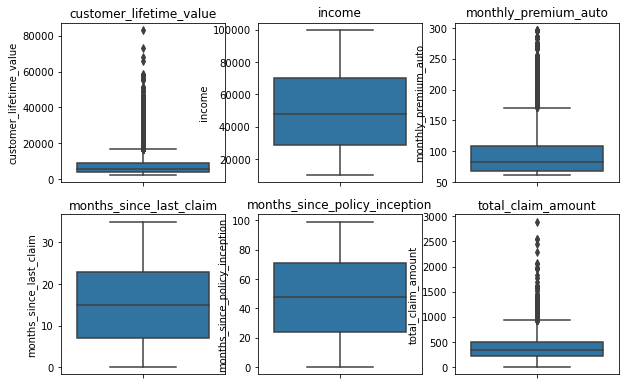

In [223]:
boxplots_for_all_numerical_cols(split_df_by(ca_no_zero_income_df)[0])

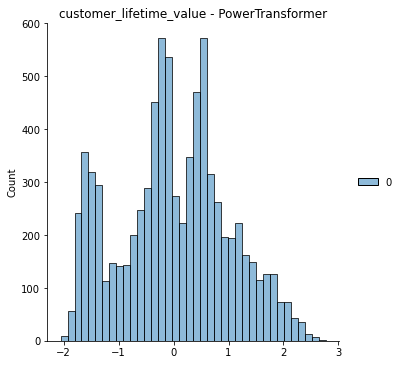

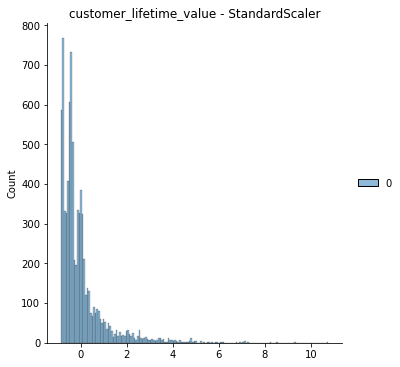

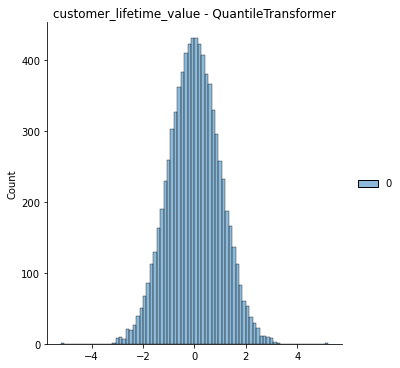

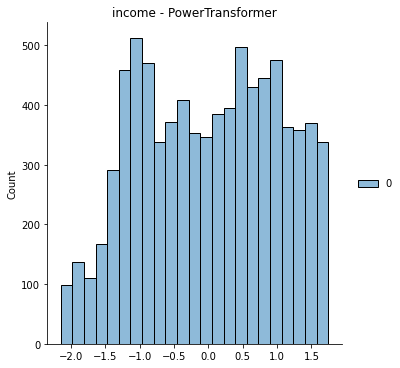

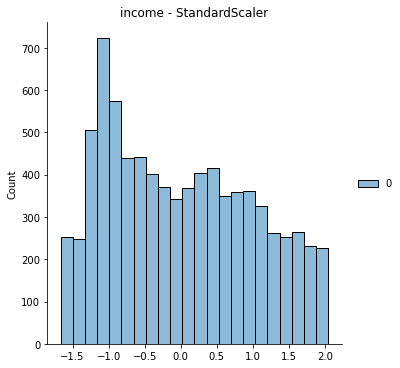

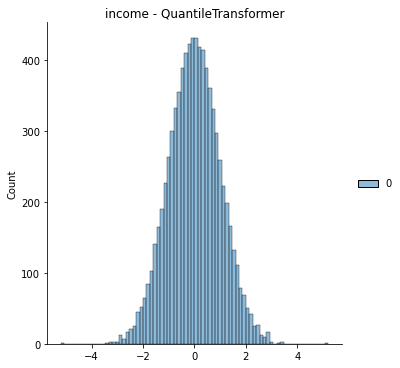

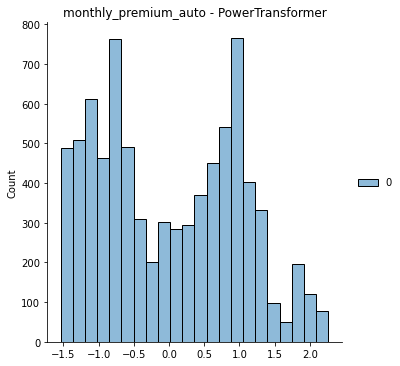

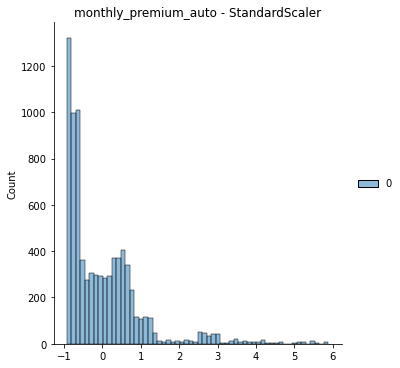

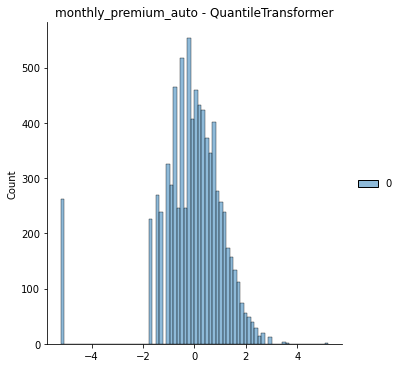

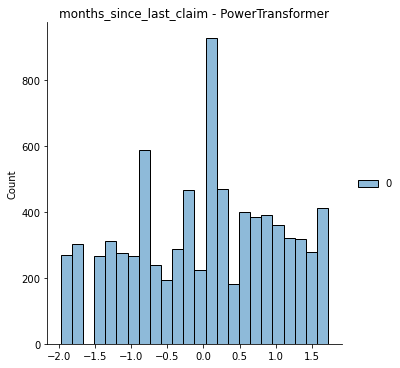

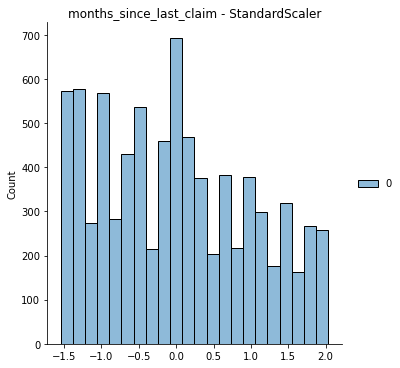

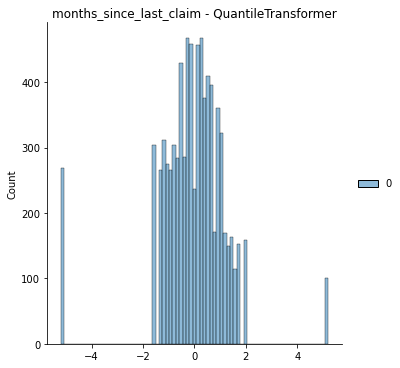

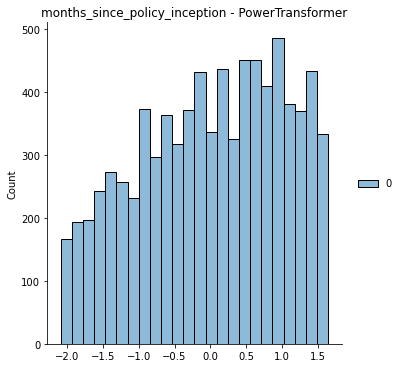

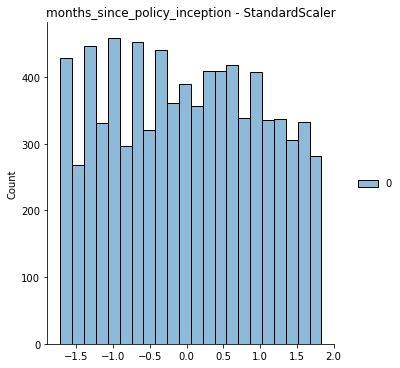

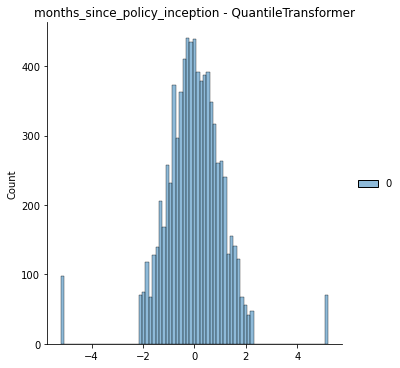

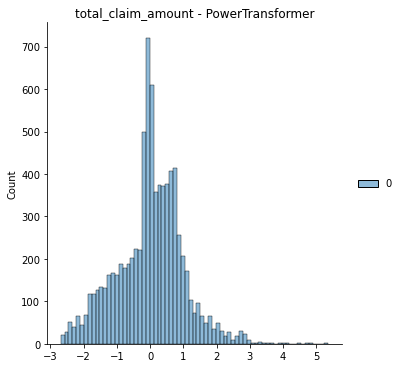

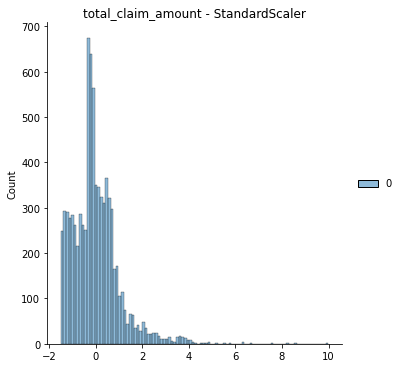

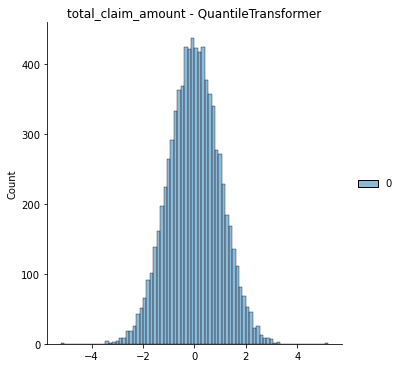

In [224]:
for col in split_column_names_by(ca_no_zero_income_df)[0]:
    plot_hist_normalized(ca_no_zero_income_df[col])

In [226]:
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
ca_no_zero_income_df["customer_lifetime_value_qt"] = qt.fit_transform(ca_no_zero_income_df["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["income_qt"] = qt.fit_transform(ca_no_zero_income_df["income"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["monthly_premium_auto_qt"] = qt.fit_transform(ca_no_zero_income_df["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["months_since_last_claim_qt"] = qt.fit_transform(ca_no_zero_income_df["months_since_last_claim"].to_numpy().reshape(-1,1))
ca_no_zero_income_df["months_since_policy_inception_qt"] = qt.fit_transform(ca_no_zero_income_df["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_no_zero_income_df.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)


C:\Users\roman\AppData\Local\Temp/ipykernel_11380/3645215873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_no_zero_income_df["customer_lifetime_value_qt"] = qt.fit_transform(ca_no_zero_income_df["customer_lifetime_value"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Temp/ipykernel_11380/3645215873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_no_zero_income_df["income_qt"] = qt.fit_transform(ca_no_zero_income_df["income"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Tem

**Categorical**

In [227]:
categoricals_features= ca_no_zero_income_df.select_dtypes("object")
cat_cols_no_zero_income=pd.get_dummies(categoricals_features, drop_first=True)

In [228]:
cat_cols_no_zero_income

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
10903,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### X-y split

In [229]:
X=ca_no_zero_income_df.drop("total_claim_amount", axis=1)
y=ca_no_zero_income_df["total_claim_amount"]

In [230]:
X_num=X._get_numeric_data()
X_num

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt
0,-0.442432,-0.004804,-5.199338,-0.635580,0.118323
2,1.226274,-1.170743,0.402420,2.013252,-0.454737
3,1.624785,0.027116,0.332543,-0.383428,-1.785697
4,0.659579,-1.023183,1.026599,0.100636,-0.454737
5,-0.470810,0.063463,-5.199338,-1.358362,0.737330
...,...,...,...,...,...
10902,-0.820847,-0.680330,0.192060,-0.383428,-0.482771
10903,-1.206187,0.340674,-0.192060,1.315396,1.070111
10906,-0.235764,0.391770,-1.065669,-0.635580,0.575238
10907,1.717269,-0.231646,2.061689,-0.295601,0.432565


array([[<AxesSubplot:title={'center':'customer_lifetime_value_qt'}>,
        <AxesSubplot:title={'center':'income_qt'}>],
       [<AxesSubplot:title={'center':'monthly_premium_auto_qt'}>,
        <AxesSubplot:title={'center':'months_since_last_claim_qt'}>],
       [<AxesSubplot:title={'center':'months_since_policy_inception_qt'}>,
        <AxesSubplot:>]], dtype=object)

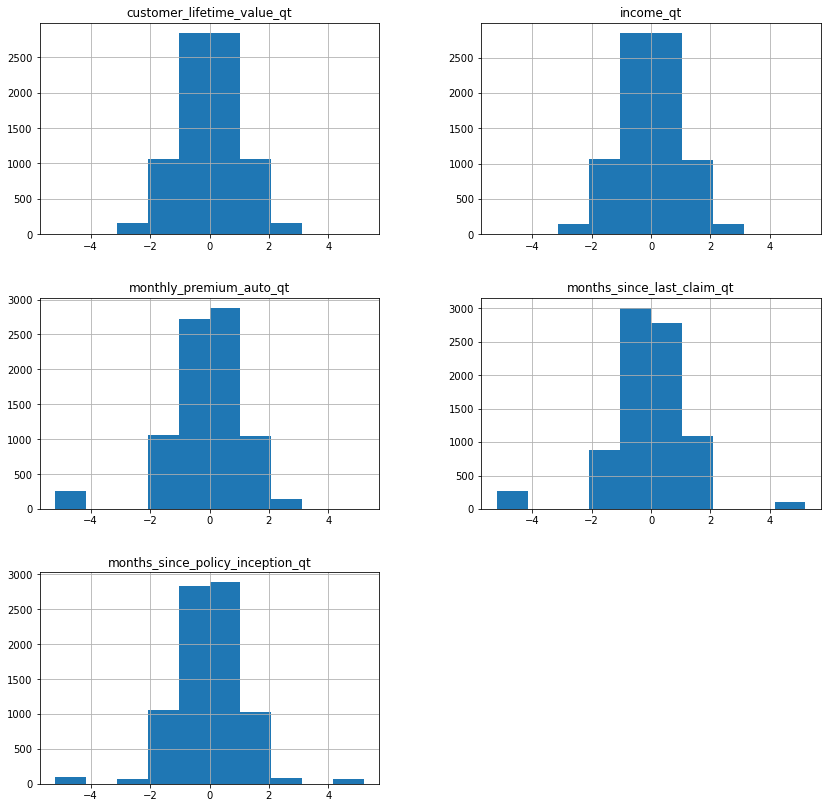

In [232]:
X_num.hist(figsize=(14,14))

#### Data splitting

In [233]:
X_train, X_test, y_train, y_test=train_test_split(X_num, y, test_size=.30,random_state=42)

#### Standardize
+ Build scaling parameters on training set (mean variance)<br>



In [234]:
std_scaler=StandardScaler().fit(X_train)

+ Apply on training set

In [235]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

+ as well as on test set (same std_scaler but generated by a bigger set of values)

In [236]:
X_test_scaled=std_scaler.transform(X_test)

In [79]:
# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)

#### Modeling using Statsmodels

In [237]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     413.8
Date:                Tue, 01 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:27:52   Log-Likelihood:                -38503.
No. Observations:                5686   AIC:                         7.702e+04
Df Residuals:                    5680   BIC:                         7.706e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.1056      2.802    134.586      0.0

In [238]:
predictions_test

array([327.23647217, 418.27352676, 369.10387444, ..., 444.38612348,
       309.68810086, 582.0564873 ])

In [ ]:
#display adjusted R-squared
# print(model.rsquared_adj)

#### Modeling using Scikit Learn

##### Model fitting

In [240]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### Parameters of model

In [242]:
model.coef_

array([ 23.39109606, -54.61485905, 104.06560547,  -2.68287879,
        -0.10695084])

In [243]:
model.intercept_

377.10556387776995

y = 377.11 + <br>23.39 * customer_lifetime_value  - 54.61 * income + 104.07 * monthly_premium_auto - 2.68 * months_since_last_claim - 0.11 * months_since_policy_inception 

In [245]:
model.score(X_test_scaled,y_test)

0.26691041435525253

##### Making prediction

In [246]:
y_pred=model.predict(X_test_scaled)

In [247]:
y_test

2625     389.636991
6302     497.047297
7355     527.139074
8803       5.746657
7944    1108.800000
           ...     
5157     114.815893
635      574.024018
2601      40.839965
5088     171.184016
1077     888.000000
Name: total_claim_amount, Length: 2437, dtype: float64

In [249]:
len(y_pred)

2437

In [250]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### Plots

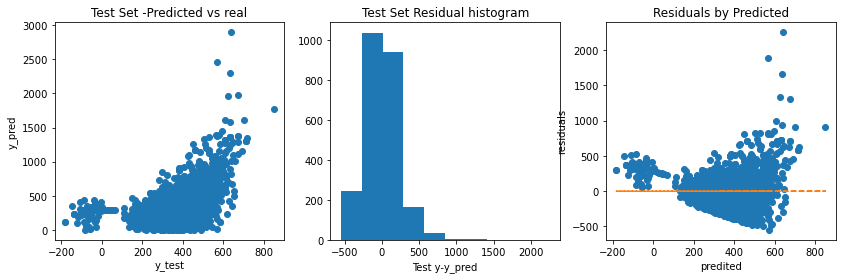

In [251]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

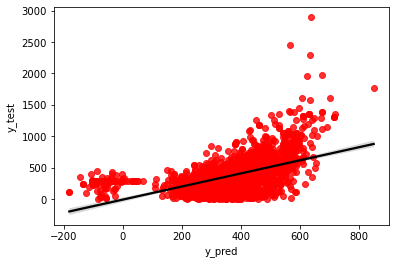

In [252]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### Error metrics

In [254]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

51007.61933961263
159.18205508216533


### Dataframe with 0 income replaced by mean income

+ mean of income *including* the 0 incomes

In [291]:
np.mean(ca_df["income"])

50414.978086911266

+ mean of income *excluding* 0 incomes

In [292]:
np.mean(ca_df[ca_df["income"] != 0]["income"])

50414.978086911266

In [294]:
ca_zero_income_mean_df = ca_df

Index(['state', 'customer_lifetime_value', 'response', 'coverage', 'education',
       'employmentstatus', 'gender', 'income', 'location_code',
       'marital_status', 'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size',
       'vehicle_type', 'month'],
      dtype='object')

In [297]:
ca_zero_income_mean_df['income']=ca_zero_income_mean_df['income'].replace(0, np.mean(ca_df[ca_df["income"] != 0]["income"]))


#### Different transformations (zero income dropped)

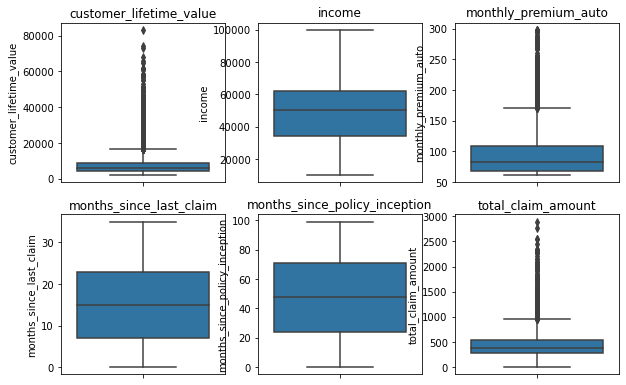

In [289]:
boxplots_for_all_numerical_cols(split_df_by(ca_zero_income_mean_df)[0])

C:\Users\roman\Python\anaconda\envs\DA_Env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


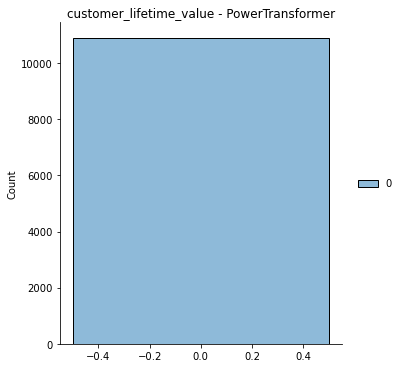

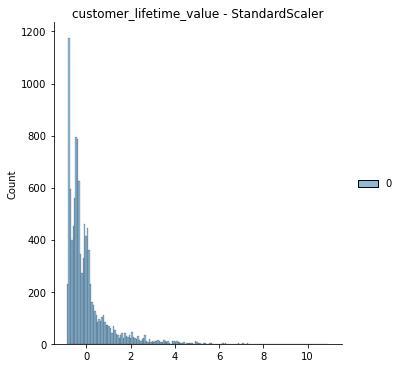

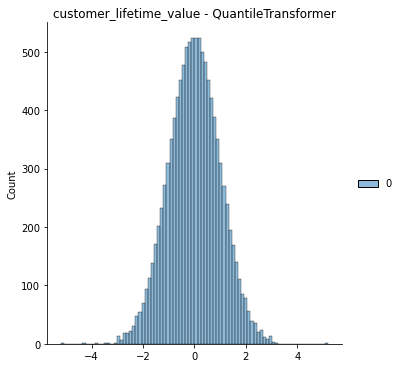

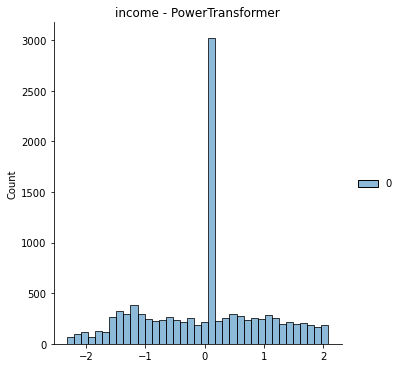

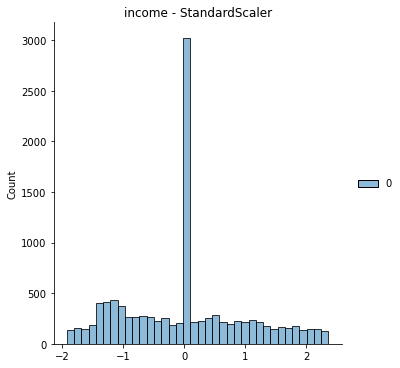

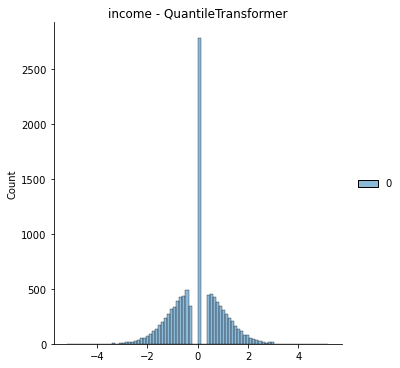

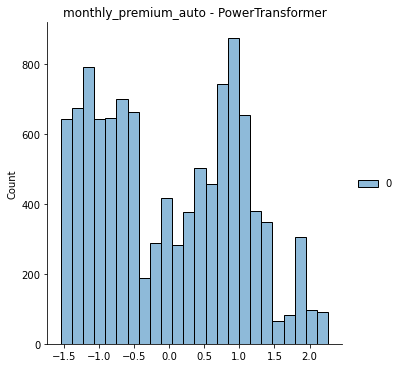

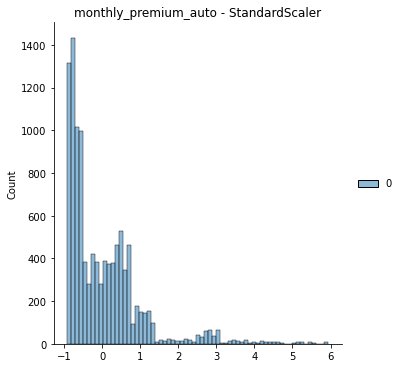

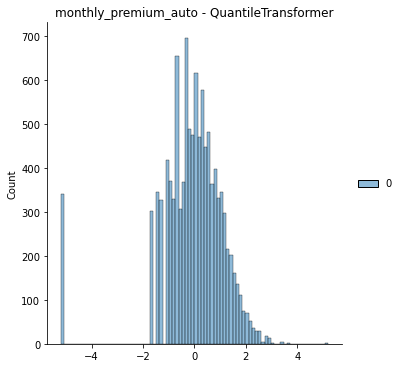

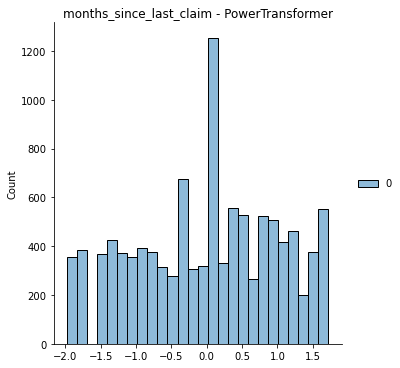

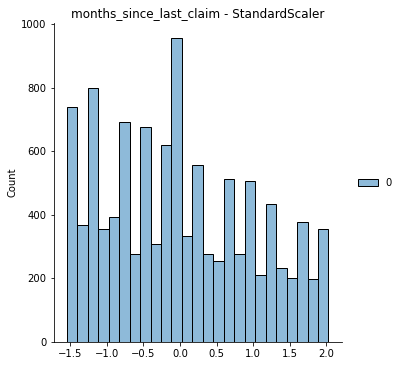

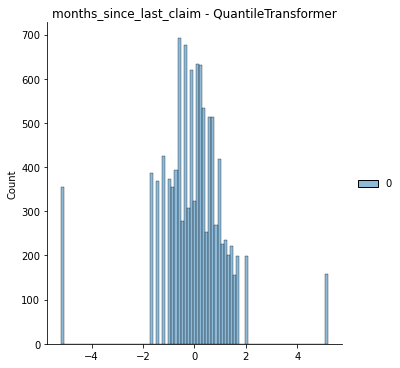

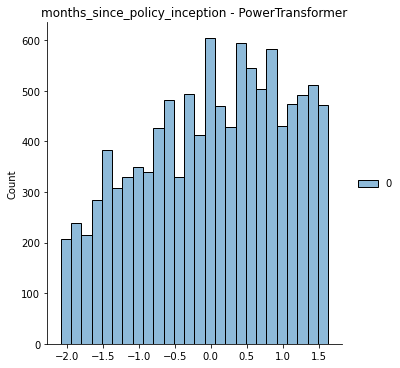

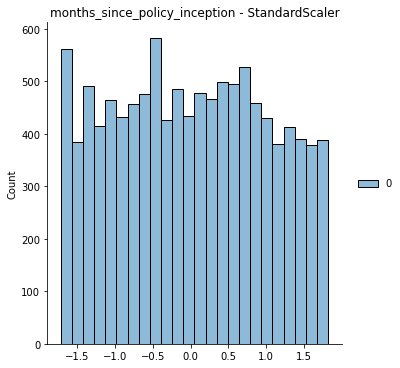

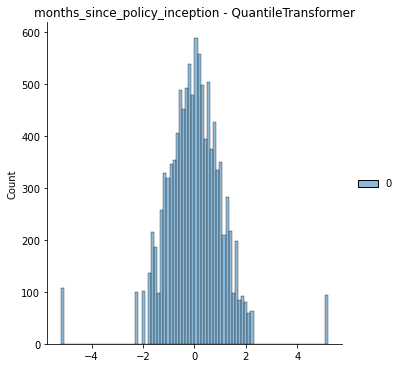

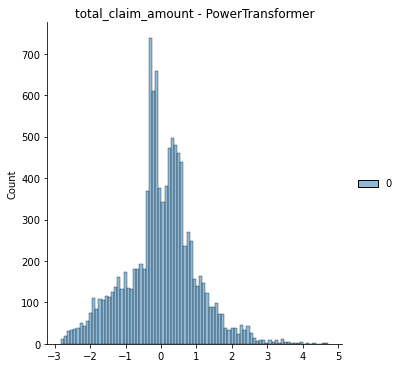

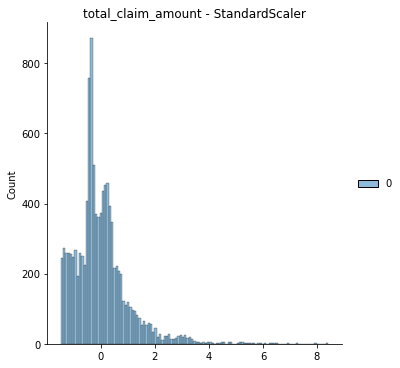

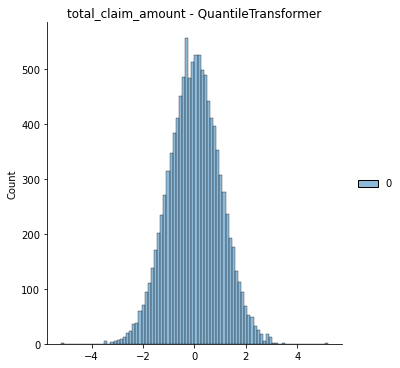

In [282]:
for col in split_column_names_by(ca_zero_income_mean_df)[0]:
    plot_hist_normalized(ca_zero_income_mean_df[col])

In [298]:
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
ca_zero_income_mean_df["customer_lifetime_value_qt"] = qt.fit_transform(ca_zero_income_mean_df["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["income_qt"] = qt.fit_transform(ca_zero_income_mean_df["income"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["monthly_premium_auto_qt"] = qt.fit_transform(ca_zero_income_mean_df["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["months_since_last_claim_qt"] = qt.fit_transform(ca_zero_income_mean_df["months_since_last_claim"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df["months_since_policy_inception_qt"] = qt.fit_transform(ca_zero_income_mean_df["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_zero_income_mean_df.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)

**Categorical**

In [299]:
categoricals_features= ca_zero_income_mean_df.select_dtypes("object")
cat_cols_zero_income_mean=pd.get_dummies(categoricals_features, drop_first=True)


In [300]:
cat_cols_zero_income_mean

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
10906,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
10908,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0


#### X-y split

In [302]:
X=ca_zero_income_mean_df.drop("total_claim_amount", axis=1)
y=ca_zero_income_mean_df["total_claim_amount"]

In [303]:
X_num=X._get_numeric_data()
X_num

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt
0,-0.394156,-0.329890,-5.199338,-0.641740,0.110739
1,-2.336103,0.045225,-1.246925,-1.168798,-0.623332
2,1.239759,-1.342359,0.394263,1.976518,-0.463109
3,1.667594,-0.305638,0.327239,-0.391550,-1.811004
4,0.680647,-1.204088,0.993141,0.093065,-0.463109
...,...,...,...,...,...
10905,1.285817,0.045225,2.566000,0.093065,-0.212569
10906,-0.195135,0.647952,-1.079060,-0.641740,0.566370
10907,1.753037,-0.511949,2.106144,-0.308746,0.424306
10908,0.989715,0.732501,1.621036,-5.199338,-0.593112


array([[<AxesSubplot:title={'center':'customer_lifetime_value_qt'}>,
        <AxesSubplot:title={'center':'income_qt'}>],
       [<AxesSubplot:title={'center':'monthly_premium_auto_qt'}>,
        <AxesSubplot:title={'center':'months_since_last_claim_qt'}>],
       [<AxesSubplot:title={'center':'months_since_policy_inception_qt'}>,
        <AxesSubplot:>]], dtype=object)

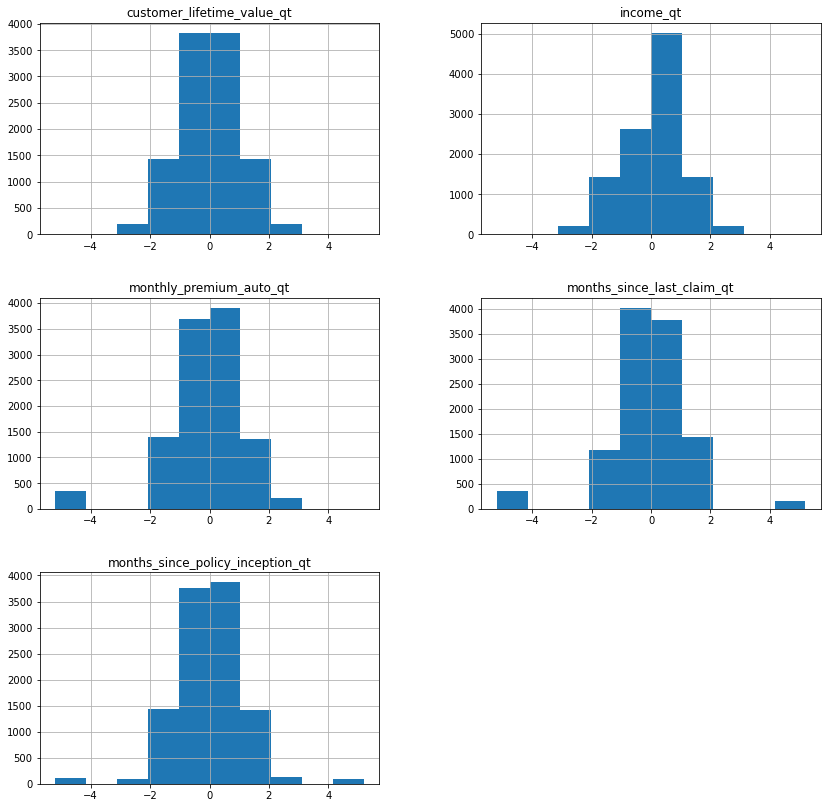

In [304]:
X_num.hist(figsize=(14,14))

#### Data splitting

In [306]:
X_train, X_test, y_train, y_test=train_test_split(X_num, y, test_size=.30,random_state=42)

#### Standardize

+ Build scaling parameters on training set (mean variance)

In [307]:
std_scaler=StandardScaler().fit(X_train)

+ Apply on training set

In [310]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

+ as well as on test set (same std_scaler but generated by a bigger set of values)

In [311]:
X_test_scaled=std_scaler.transform(X_test)

# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)


#### Modeling using Statsmodels

In [312]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

In [313]:
model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     504.3
Date:                Tue, 01 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:21:16   Log-Likelihood:                -53154.
No. Observations:                7637   AIC:                         1.063e+05
Df Residuals:                    7631   BIC:                         1.064e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        435.4308      2.919    149.186      0.0

In [314]:
predictions_test

array([315.06469349, 432.21820384, 324.24054895, ..., 535.58887653,
       327.26233371, 499.08406521])

In [328]:
# display adjusted R-squared
# print(model.rsquared_adj)


AttributeError: 'LinearRegression' object has no attribute 'rsquared_adj'

#### Modeling using Scikit Learn

##### Model fitting

In [315]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### Parameters of model

In [317]:
print("Coefficients:\n", model.coef_)
print("Interecept:", model.intercept_)

Coefficients:
 [ 16.04198442 -47.17551679 131.36476734   3.76437625   1.69599943]
Interecept: 435.4308038059447


y = 435.43 + <br>
16.04 * customer_lifetime_value  - 47.18 * income + 131.36 * monthly_premium_auto + 3.76 * months_since_last_claim + 1.70 * months_since_policy_inception 


In [318]:
model.score(X_test_scaled,y_test)

0.2389734505045903

##### Making prediction

In [319]:
y_pred=model.predict(X_test_scaled)

In [320]:
y_test

4829     475.423848
5081     350.400000
5011     482.400000
4625     673.342650
3838     302.400000
            ...    
9968     144.728404
5239      93.566940
10001    253.637853
4828     284.000172
10483    485.183645
Name: total_claim_amount, Length: 3273, dtype: float64

In [321]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### Plots

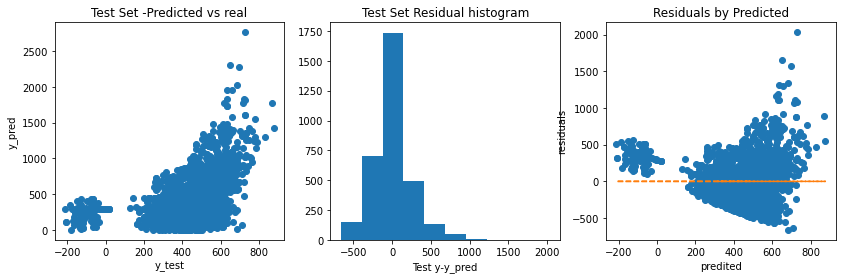

In [324]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

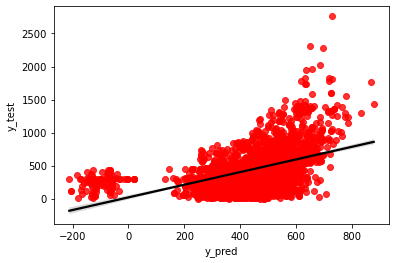

In [325]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})


##### Error metrics


In [326]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

62963.40448538024
178.74498440720058


***

***

In [ ]:
### BELOW is old code snippets which will be reused or (more likely) trashed

In [218]:
cat_col=pd.get_dummies(X["state"], drop_first=False)
cat_col

,Arizona,California,Nevada,Oregon,Washington
0,1,0,0,0,0
2,0,0,0,0,1
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,0,0
...,...,...,...,...,...
10902,0,1,0,0,0
10903,1,0,0,0,0
10906,0,0,0,1,0
10907,1,0,0,0,0


In [232]:
# # get dummies pandas
# categoricals_features=pd.get_dummies(categoricals_features, drop_first=True)
# categoricals_features
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(categoricals_features).toarray())
##columns=OneHotEncoder(drop='first').fit(categoricals_features).get_feature_names(input_features=categoricals_feature##s.columns)).head()

,0,1,2,3,4,5,6,7,8,9,...,6906,6907,6908,6909,6910,6911,6912,6913,6914,6915
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [226]:
categoricals_features= X.select_dtypes("object")
categoricals_features

,customer,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,vehicle_type
0,DK49336,Arizona,No,Basic,College,2/18/11,Employed,M,Suburban,Married,Corporate Auto,Corporate L3,Offer3,Agent,Four-Door Car,Medsize,NaN
2,LZ68649,Washington,No,Basic,Bachelor,2/10/11,Employed,M,Suburban,Single,Personal Auto,Personal L3,Offer3,Call Center,SUV,Medsize,A
3,XL78013,Oregon,Yes,Extended,College,1/11/11,Employed,M,Suburban,Single,Corporate Auto,Corporate L3,Offer2,Branch,Four-Door Car,Medsize,A
4,QA50777,Oregon,No,Premium,Bachelor,1/17/11,Medical Leave,F,Suburban,Married,Personal Auto,Personal L2,Offer1,Branch,Four-Door Car,Medsize,NaN
5,HO81102,NaN,NaN,Basic,High School or Below,2/14/11,Employed,M,Suburban,Divorced,Personal Auto,Personal L3,Offer1,Agent,Four-Door Car,Medsize,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,PP30874,California,No,Extended,High School or Below,1/24/11,Employed,F,Suburban,Married,Personal Auto,Personal L2,Offer2,Agent,Four-Door Car,Medsize,A
10903,SU71163,Arizona,No,Basic,College,1/7/11,Employed,M,Suburban,Married,Personal Auto,Personal L2,Offer2,Branch,Two-Door Car,Medsize,A
10906,KX53892,Oregon,No,Basic,College,1/6/11,Employed,F,Urban,Married,Personal Auto,Personal L3,Offer2,Branch,Four-Door Car,Medsize,A
10907,TL39050,Arizona,No,Extended,Bachelor,2/6/11,Employed,F,Rural,Married,Corporate Auto,Corporate L3,Offer1,Web,Luxury SUV,Medsize,NaN


select some discrete columns

In [233]:
X = X[[
 'state',
 'response',
 'coverage',
 'education',
 'effective_to_date',
 'employmentstatus',
 'gender',
 'location_code',
 'marital_status',
 'number_of_open_complaints',
 'number_of_policies',
 'policy_type',
 'policy',
 'renew_offer_type',
 'sales_channel',
 'vehicle_class',
 'vehicle_size',
 'vehicle_type',
 ]]

In [234]:
categoricals_features= X.select_dtypes("object")
categoricals_features

,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,vehicle_type
0,Arizona,No,Basic,College,2/18/11,Employed,M,Suburban,Married,Corporate Auto,Corporate L3,Offer3,Agent,Four-Door Car,Medsize,NaN
2,Washington,No,Basic,Bachelor,2/10/11,Employed,M,Suburban,Single,Personal Auto,Personal L3,Offer3,Call Center,SUV,Medsize,A
3,Oregon,Yes,Extended,College,1/11/11,Employed,M,Suburban,Single,Corporate Auto,Corporate L3,Offer2,Branch,Four-Door Car,Medsize,A
4,Oregon,No,Premium,Bachelor,1/17/11,Medical Leave,F,Suburban,Married,Personal Auto,Personal L2,Offer1,Branch,Four-Door Car,Medsize,NaN
5,NaN,NaN,Basic,High School or Below,2/14/11,Employed,M,Suburban,Divorced,Personal Auto,Personal L3,Offer1,Agent,Four-Door Car,Medsize,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,California,No,Extended,High School or Below,1/24/11,Employed,F,Suburban,Married,Personal Auto,Personal L2,Offer2,Agent,Four-Door Car,Medsize,A
10903,Arizona,No,Basic,College,1/7/11,Employed,M,Suburban,Married,Personal Auto,Personal L2,Offer2,Branch,Two-Door Car,Medsize,A
10906,Oregon,No,Basic,College,1/6/11,Employed,F,Urban,Married,Personal Auto,Personal L3,Offer2,Branch,Four-Door Car,Medsize,A
10907,Arizona,No,Extended,Bachelor,2/6/11,Employed,F,Rural,Married,Corporate Auto,Corporate L3,Offer1,Web,Luxury SUV,Medsize,NaN


In [235]:
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(categoricals_features).toarray())


,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [78]:
# yj = PowerTransformer(method="yeo-johnson")
# no_zero_income_transformed_yj=pt.fit_transform(ca_no_zero_income_df["income"].to_numpy().reshape(-1,1))
# sns.displot(no_zero_income_transformed_yj)